In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

Data SO2 preparation

In [2]:
# Total SO2 preparation
# Load CSV
df_csv = pd.read_csv('/Users/Jia/Downloads/data_skripsi/SO_2/so2_arrange.csv')

In [3]:
# Mengonversi kolom 'time' ke tipe data datetime
df_csv['time'] = pd.to_datetime(df_csv['time'])

# Menambahkan kolom 'month'
df_csv['month'] = df_csv['time'].dt.month

# Menambahkan kolom 'year'
df_csv['year'] = df_csv['time'].dt.year

# Melakukan group by bulan, longitude, dan latitude, dan menghitung rata-rata so2
so2_mean_monthly = df_csv.groupby(['month', 'year', 'longitude', 'latitude'], as_index=False)['so2'].mean()

In [4]:
df_csv = df_csv.iloc[21600:54001, :]

Spatial Join df and gdf

In [5]:
# Load shapefile into a GeoDataFrame
gdf_shapefile = gpd.read_file(r"/Users/Jia/Downloads/data_skripsi/kota_DKIJakarta/Kota_DKIJakarta.shp")

In [6]:
# Convert DataFrame to GeoDataFrame
geometry = gpd.points_from_xy(df_csv['longitude'], df_csv['latitude'])
gdf_csv = gpd.GeoDataFrame(df_csv, geometry=geometry, crs="EPSG:4326")

<Axes: >

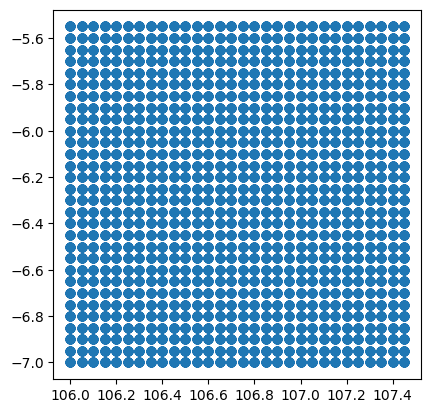

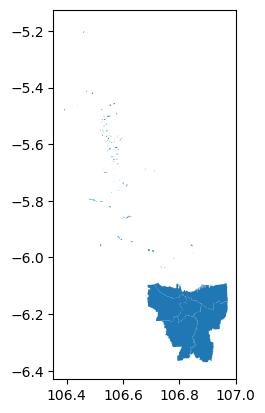

In [7]:
gdf_csv.plot()
gdf_shapefile.plot()

In [8]:
# spatial join
result = gpd.sjoin(gdf_csv, gdf_shapefile, how='inner', predicate='intersects')
result_pop = result[['longitude', 'latitude', 'so2', 'month', 'year', 'KABKOT', 'geometry', 'time']]

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 864 entries, 22006 to 53659
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   longitude  864 non-null    float64       
 1   latitude   864 non-null    float64       
 2   so2        864 non-null    float64       
 3   month      864 non-null    int32         
 4   year       864 non-null    int32         
 5   KABKOT     864 non-null    object        
 6   geometry   864 non-null    geometry      
 7   time       864 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(3), geometry(1), int32(2), object(1)
memory usage: 54.0+ KB


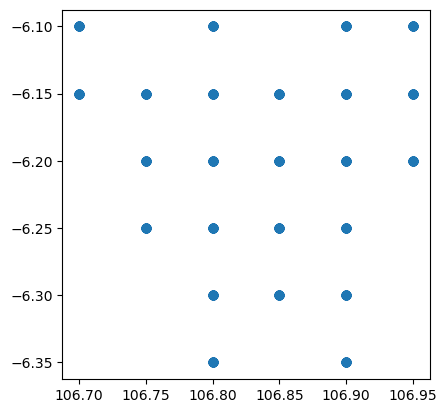

In [9]:
result_pop.plot()
result_pop.info()

Dissolved Result

In [10]:
# Dissolve berdasarkan 'KABKOT' dan 'month' dengan fungsi agregasi mean
dissolved_result = result_pop.dissolve(by=['KABKOT', 'month'], aggfunc='mean')

# Reset indeks untuk membuat kolom 'KABKOT' 'month', dan 'year' menjadi kolom
dissolved_result.reset_index(inplace=True)

In [11]:
# Tampilkan hasil
dissolved_result.head()

,KABKOT,month,geometry,longitude,latitude,so2,year,time
0,JAKARTA BARAT,1,"MULTIPOINT ((106.70000 -6.15000), (106.70000 -...",106.75,-6.158333,76.301261,2021.0,2020-12-31 16:00:00
1,JAKARTA BARAT,2,"MULTIPOINT ((106.70000 -6.15000), (106.70000 -...",106.75,-6.158333,69.043076,2021.0,2021-01-31 16:00:00
2,JAKARTA BARAT,3,"MULTIPOINT ((106.70000 -6.15000), (106.70000 -...",106.75,-6.158333,94.929669,2021.0,2021-03-01 00:00:00
3,JAKARTA BARAT,4,"MULTIPOINT ((106.70000 -6.15000), (106.70000 -...",106.75,-6.158333,110.836743,2021.0,2021-04-01 00:00:00
4,JAKARTA BARAT,5,"MULTIPOINT ((106.70000 -6.15000), (106.70000 -...",106.75,-6.158333,122.767416,2021.0,2021-05-01 00:00:00


In [12]:
dissolved_result_df = pd.DataFrame(dissolved_result)
dissolved_result_df = dissolved_result_df.drop(['geometry'], axis=1) #kolom geometry di hapus

In [13]:
#untuk mengurutkan file berdasarkan
dissolved_result_df = dissolved_result_df.sort_values(by=[ 'year', 'KABKOT', 'month'])

In [14]:
polygon_result = gpd.sjoin(gdf_shapefile, dissolved_result, how='inner', predicate='intersects')

In [15]:
print(polygon_result.columns)

Index(['PROVNO', 'KABKOTNO', 'PROVINSI', 'KABKOT_left', 'geometry',
       'index_right', 'KABKOT_right', 'month', 'longitude', 'latitude', 'so2',
       'year', 'time'],
      dtype='object')


Peta Spasial Rata-Rata per Bulan Tahun 2020-2022

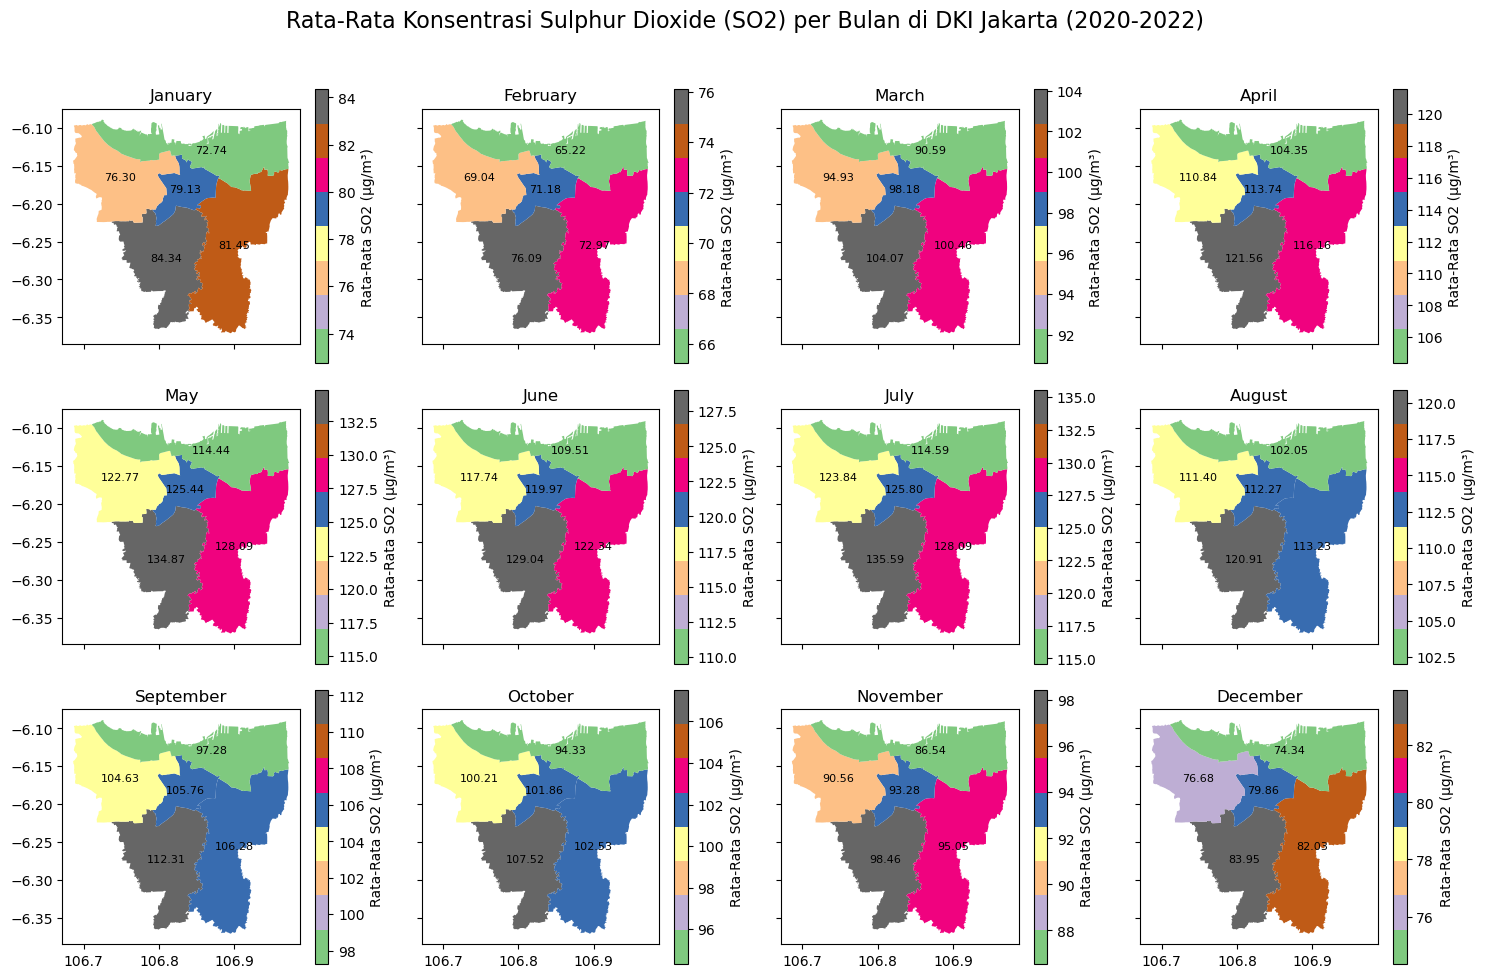

In [20]:
import calendar

# Create a figure with subplots for each month
fig, axs = plt.subplots(3, 4, figsize=(15, 10), sharex=True, sharey=True)
fig.suptitle('Rata-Rata Konsentrasi Sulphur Dioxide (SO2) per Bulan di DKI Jakarta (2020-2022)', fontsize=16)

# Iterate through each month and plot the data
for month, ax in zip(range(1, 13), axs.flatten()):
    # Filter data for the current month
    data_monthly = polygon_result[polygon_result['month'] == month]

    # Plot the map for the current month
    data_monthly.plot(ax=ax, column="so2", legend=True, legend_kwds={"label": "Rata-Rata SO2 (µg/m³)"})

    # Annotate each polygon with average SO2 value
    for idx, row in data_monthly.iterrows():
        ax.text(row.geometry.centroid.x, row.geometry.centroid.y, f"{row['so2']:.2f}", fontsize=8, ha='center', va='center')

    ax.set_title(calendar.month_name[month])  # Menggunakan modul calendar untuk mendapatkan nama bulan

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

cmap = plt.get_cmap('Accent')
plt.set_cmap(cmap)

# Show the plot
plt.show()

Grafik Siklus Bulanan SO2 Tahun 2020-2022

In [17]:
dissolved_result_df['month_name'] = pd.to_datetime(dissolved_result_df['month'], format='%m').dt.month_name()

dissolved_result_df = dissolved_result_df.set_index('month_name')

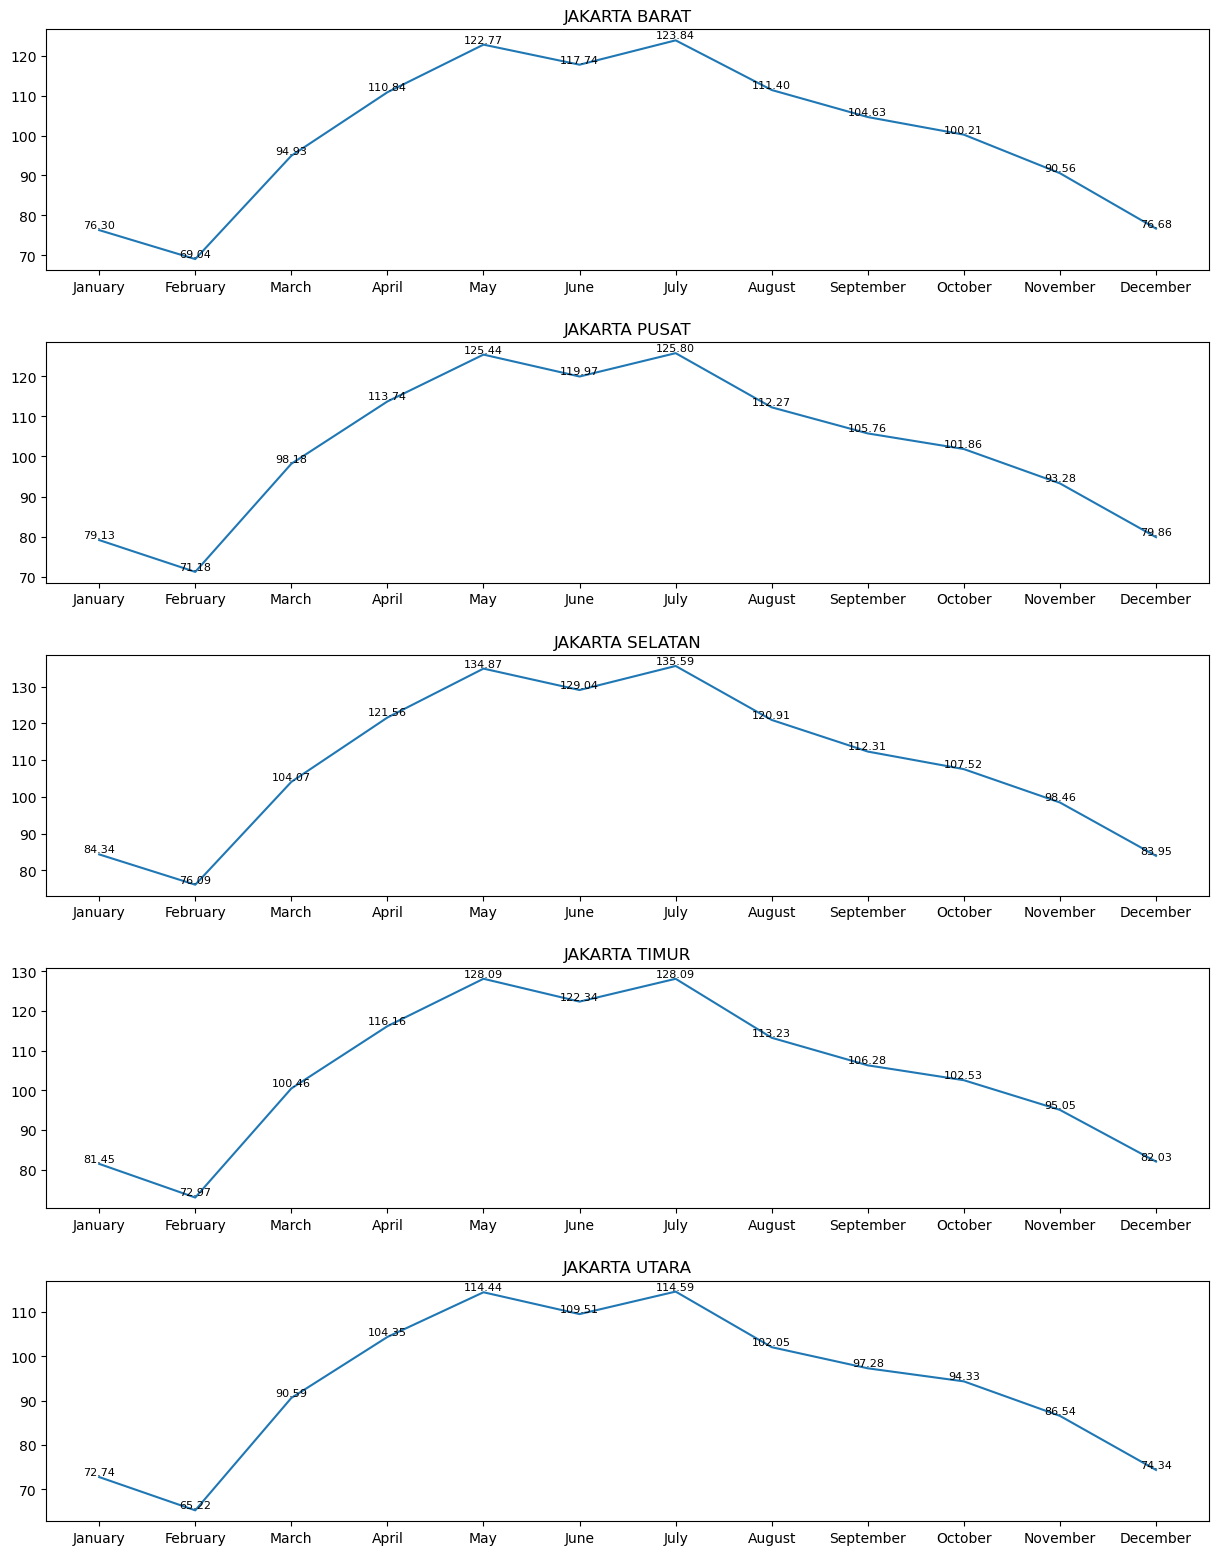

In [18]:
fig = plt.figure(figsize=(15, 60))
cities = list(dissolved_result_df['KABKOT'].unique())

# Iterate through each month and plot the data
for city, ax in zip(cities, range(1, 6)):
    # Filter data for the current wilayah admin
    data_city = dissolved_result_df[dissolved_result_df['KABKOT'] == city]

    # Plot the map for the current kabkot
    fig.add_subplot(15, 1, ax)
    plt.plot(data_city['so2'])
    plt.title(city)

    # Annotate the average So2 value for each month
    for month in range(1, 13):
        avg_so2_monthly = data_city[data_city['month'] == month]['so2'].mean()
        plt.text(month - 1, avg_so2_monthly, f"{avg_so2_monthly:.2f}",
                 ha='center', va='bottom', fontsize=8, color='black')

# Adjust layout to fit the subplots within the figure with added space
plt.subplots_adjust(hspace=0.3)

plt.show()